In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from nn import NeuralNetwork

In [2]:
data_path = 'hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<Axes: xlabel='dteday'>

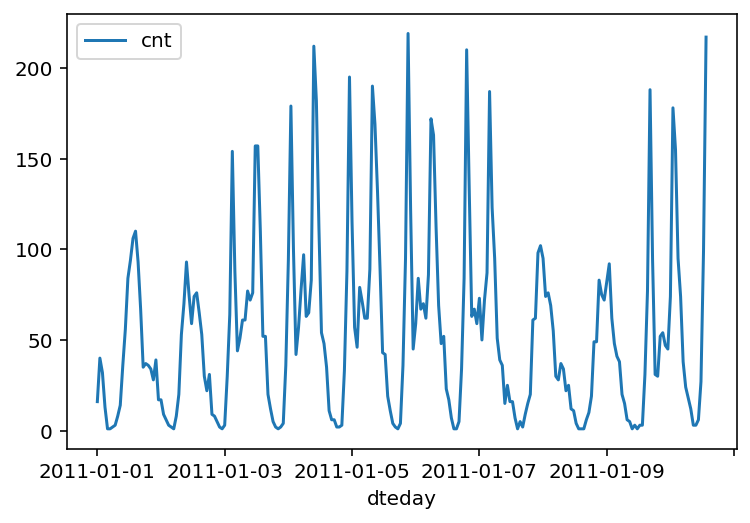

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
# Salva os dados para aproximadamente os últimos 21 dias
test_data = data[-21*24:]

# remove os dados de teste do conjunto de dados
data = data[:-21*24]

# normalizar
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Armazene escalas em um dicionário para que possamos converter de volta mais tarde
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

# Separe os dados em características e rotulo
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [7]:
# Mantenha os últimos 60 dias ou mais dos dados restantes como um conjunto de validação
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [8]:
train_targets

,cnt,casual,registered
0,-0.960480,-0.668796,-0.933742
1,-0.828686,-0.568391,-0.808452
2,-0.872617,-0.628634,-0.841423
3,-0.976954,-0.668796,-0.953525
4,-1.042851,-0.729039,-1.012872
...,...,...,...
15430,-1.015394,-0.729039,-0.979901
15431,-1.015394,-0.729039,-0.979901
15432,-0.828686,-0.688877,-0.768887
15433,-0.087343,-0.668796,0.114736


In [9]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [10]:
#################################
### Defina os hiperparâmetros ###
#################################
iterations = 800
learning_rate = 0.4
hidden_nodes = 20
output_nodes = 1


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Passe por um lote aleatório de 128 registros do conjunto de dados de treinamento
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Imprimindo o progresso do treinamento
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.700 ... Validation loss: 1.054

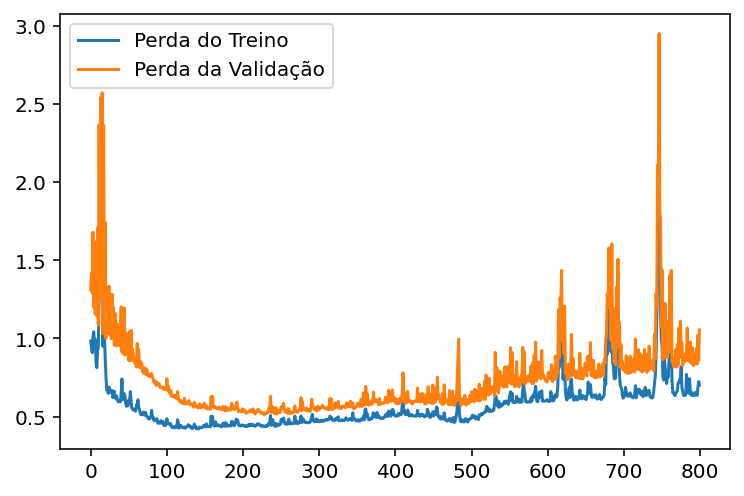

In [11]:
plt.plot(losses['train'], label='Perda do Treino')
plt.plot(losses['validation'], label='Perda da Validação')
plt.legend()
_ = plt.ylim()

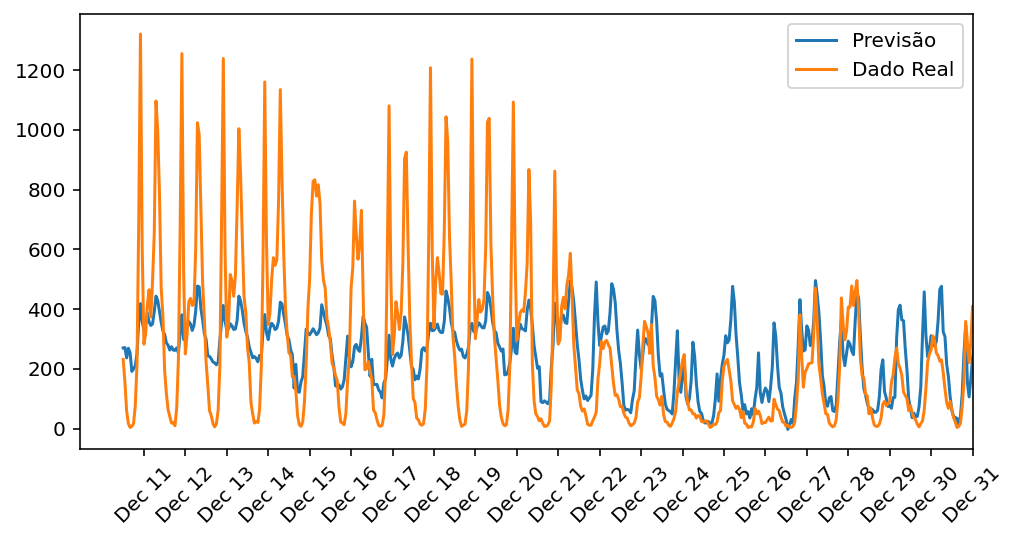

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean 
ax.plot(predictions[0], label='Previsão')
ax.plot((test_targets['cnt']*std + mean).values / 100, label='Dado Real')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)